# Mammograms Classification with YOLO

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from utils import show_batch, show_pred_example
from model import yolov1, tiny_yolov1

2025-06-25 15:20:26.566662: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 15:20:26.925479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 15:20:26.927181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-25 15:20:27.850425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Example Images

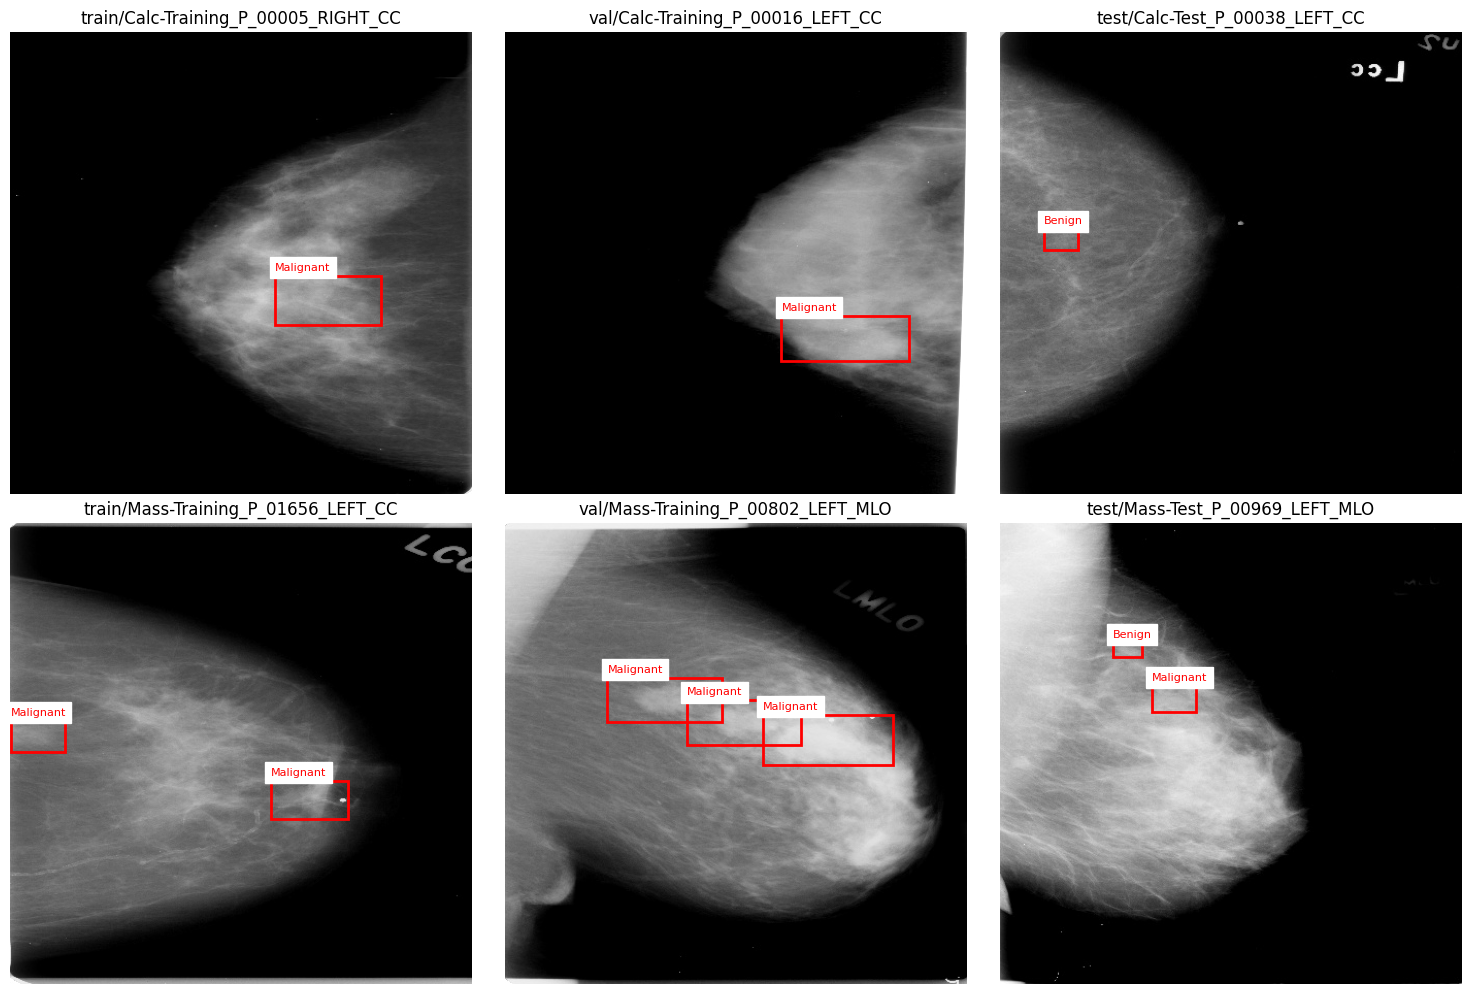

In [24]:
img_dir="data/images"
label_dir="data/labels/"
img_id = ["train/Calc-Training_P_00005_RIGHT_CC", "val/Calc-Training_P_00016_LEFT_CC", "test/Calc-Test_P_00038_LEFT_CC",
          "train/Mass-Training_P_01656_LEFT_CC", "val/Mass-Training_P_00802_LEFT_MLO", "test/Mass-Test_P_00969_LEFT_MLO" ]
show_batch(img_id, img_dir, label_dir)

## Load Model


In [3]:
model_tiny = tiny_yolov1()
model = yolov1()

2025-06-25 15:20:30.888440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-25 15:20:31.532695: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
model_tiny.summary()

Model: "tiny_yolov1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 1)]     0         
                                                                 
 convolutional_0 (Conv2D)    (None, 448, 448, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 16)     0         
 )                                                               
                                                                 
 convolutional_1 (Conv2D)    (None, 224, 224, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 convolutional_2 (Conv2D)    (None, 112, 112, 64)      

In [5]:
model.summary()

Model: "yolov1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 448, 448, 1)]     0         
                                                                 
 convolutional_0 (Conv2D)    (None, 224, 224, 64)      3200      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 convolutional_1 (Conv2D)    (None, 112, 112, 192)     602304    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 192)      0         
 2D)                                                             
                                                                 
 convolutional_2 (Conv2D)    (None, 56, 56, 128)       24704

In [6]:
model_tiny.load_weights('checkpoints/tiny_yolo_best.h5')
model.load_weights('checkpoints/yolo_best.h5')

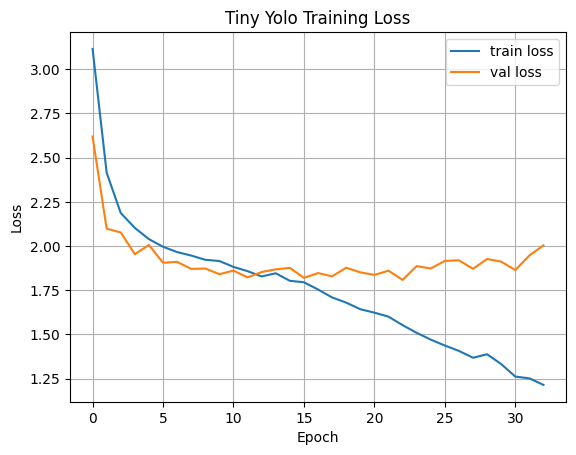

In [7]:
history_tiny_df = pd.read_csv('history/training_tiny.csv')

plt.plot(history_tiny_df['loss'], label='train loss')
plt.plot(history_tiny_df['val_loss'], label='val loss')
plt.legend()
plt.title("Tiny Yolo Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.savefig("graphs/tiny_yolo_training.png", dpi=400, bbox_inches='tight')

plt.show()

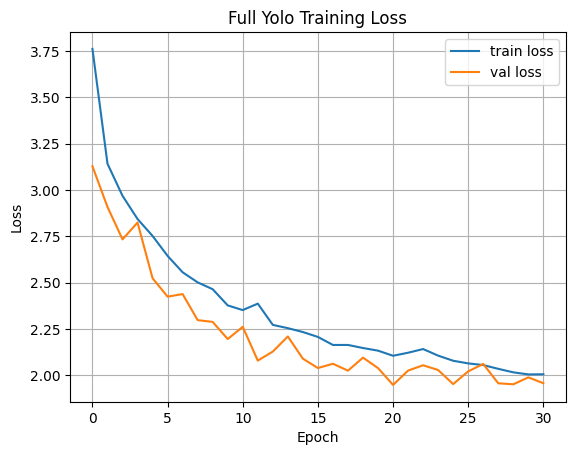

In [8]:
history_df = pd.read_csv('history/training.csv')

plt.plot(history_df['loss'], label='train loss')
plt.plot(history_df['val_loss'], label='val loss')
plt.legend()
plt.title("Full Yolo Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.savefig("graphs/yolo_training.png", dpi=400, bbox_inches='tight')

plt.show()

## Performance

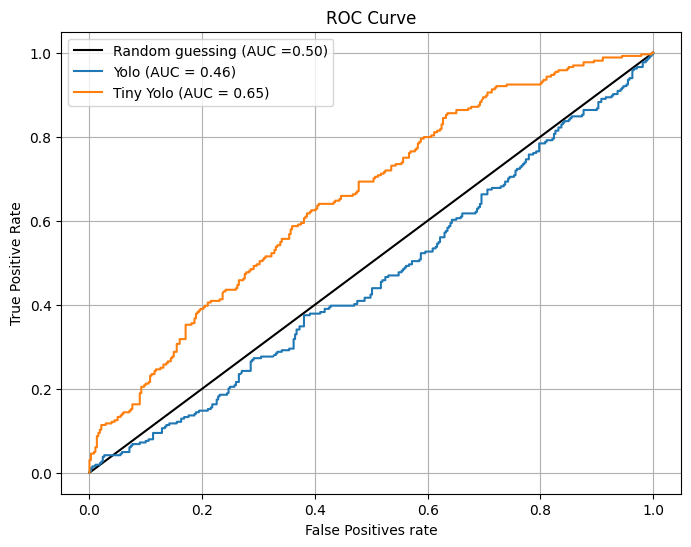

In [9]:
roc_tiny_df = pd.read_csv('performance/tiny_yolo_roc_curve.csv')
roc_df = pd.read_csv('performance/yolo_roc_curve.csv')

auc_tiny = roc_tiny_df["ROC_AUC"][0]
auc = roc_df["ROC_AUC"][0]


plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='black', label='Random guessing (AUC =0.50)')
plt.plot(roc_df['FalsePositiveRate'], roc_df['TruePositiveRate'], label=f"Yolo (AUC = {auc:.2f})")
plt.plot(roc_tiny_df['FalsePositiveRate'], roc_tiny_df['TruePositiveRate'], label=f"Tiny Yolo (AUC = {auc_tiny:.2f})")
plt.xlabel("False Positives rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve")
plt.legend()
plt.grid(True)

plt.savefig("graphs/roc.png", dpi=400, bbox_inches='tight')

plt.show()

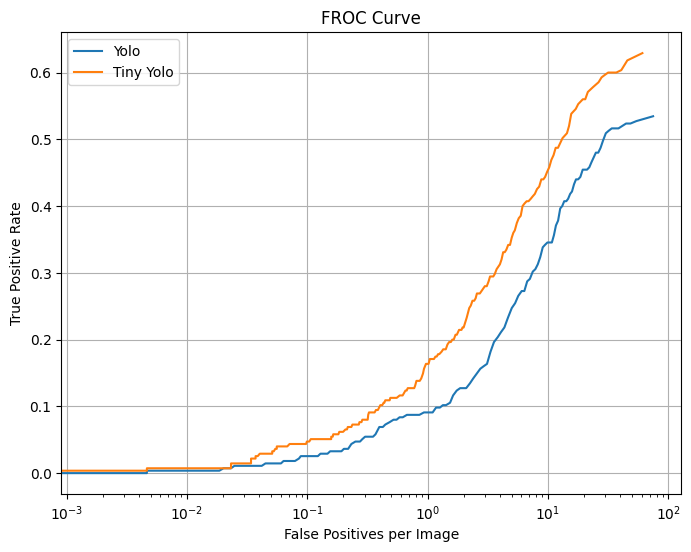

In [10]:
froc_tiny_df = pd.read_csv('performance/tiny_yolo_froc_curve.csv')
froc_df = pd.read_csv('performance/yolo_froc_curve.csv')


plt.figure(figsize=(8, 6))
plt.plot(froc_df['FalsePositivesPerImage'], froc_df['Sensitivity'], label=f"Yolo")
plt.plot(froc_tiny_df['FalsePositivesPerImage'], froc_tiny_df['Sensitivity'], label=f"Tiny Yolo")
plt.xlabel("False Positives per Image")
plt.ylabel("True Positive Rate")
plt.xscale('log')
plt.title(f"FROC Curve")
plt.legend()
plt.grid(True)

plt.savefig("graphs/froc.png", dpi=400, bbox_inches='tight')
plt.show()

## Prediction Examples

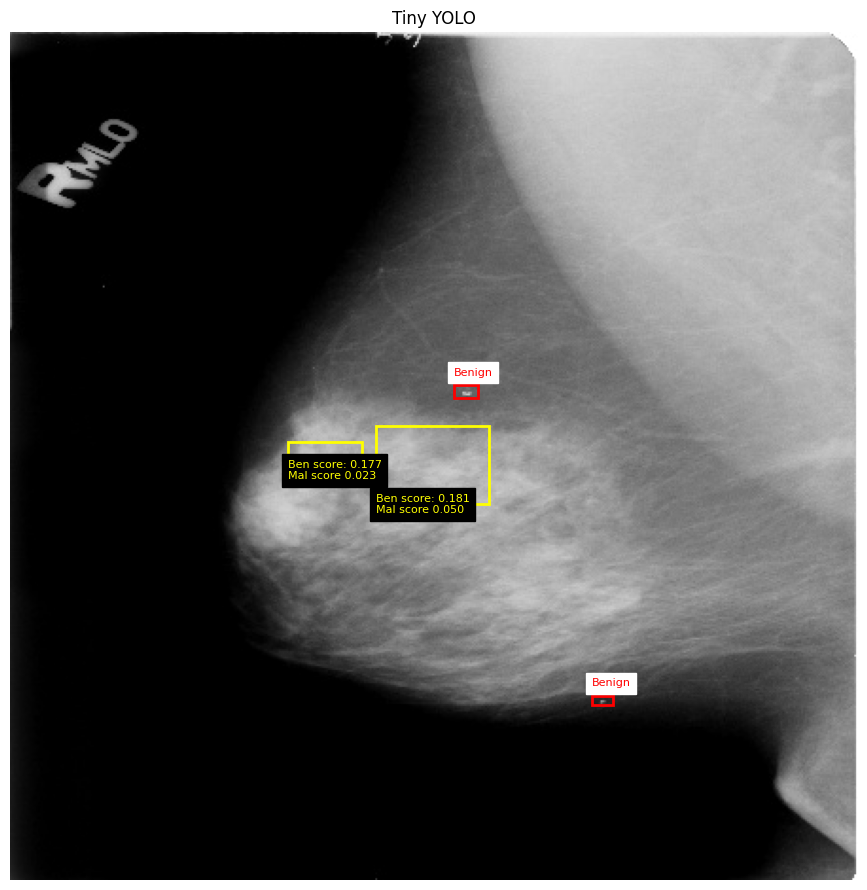

In [11]:
show_pred_example(model_tiny, "data/images/test/Calc-Test_P_01211_RIGHT_MLO.jpg", "data/labels/test/Calc-Test_P_01211_RIGHT_MLO.txt",
                         2, "Tiny YOLO" )

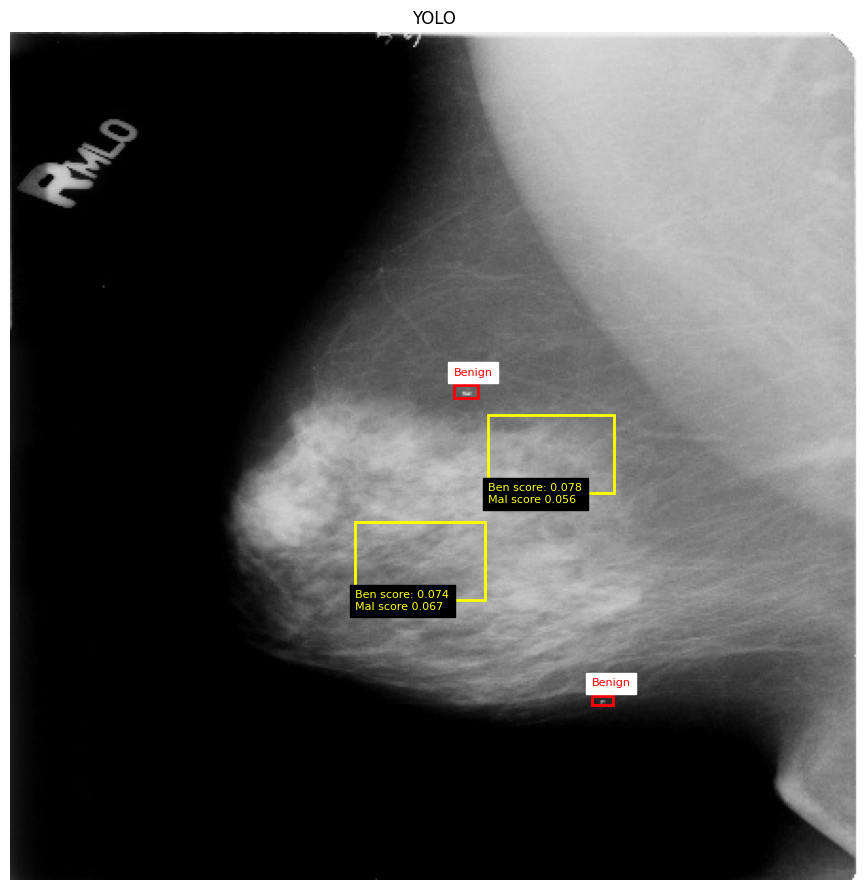

In [28]:
show_pred_example(model, "data/images/test/Calc-Test_P_01211_RIGHT_MLO.jpg", "data/labels/test/Calc-Test_P_01211_RIGHT_MLO.txt",
                         2, "YOLO" )

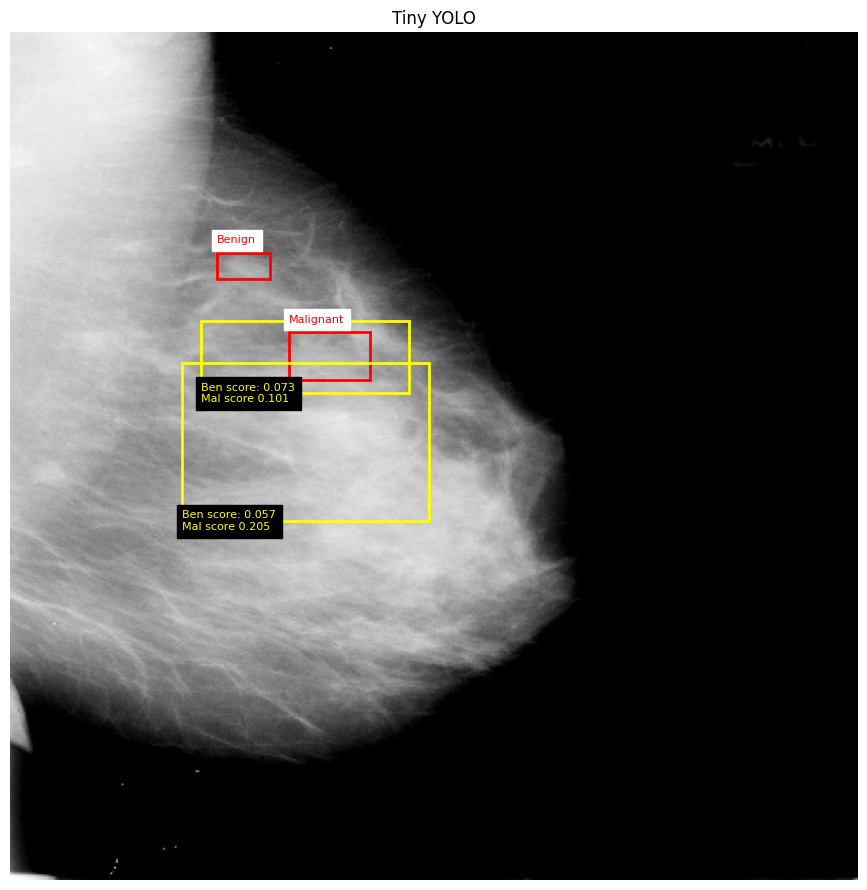

In [25]:
show_pred_example(model_tiny, "data/images/test/Mass-Test_P_00969_LEFT_MLO.jpg", "data/labels/test/Mass-Test_P_00969_LEFT_MLO.txt",
                         2, "Tiny YOLO" )

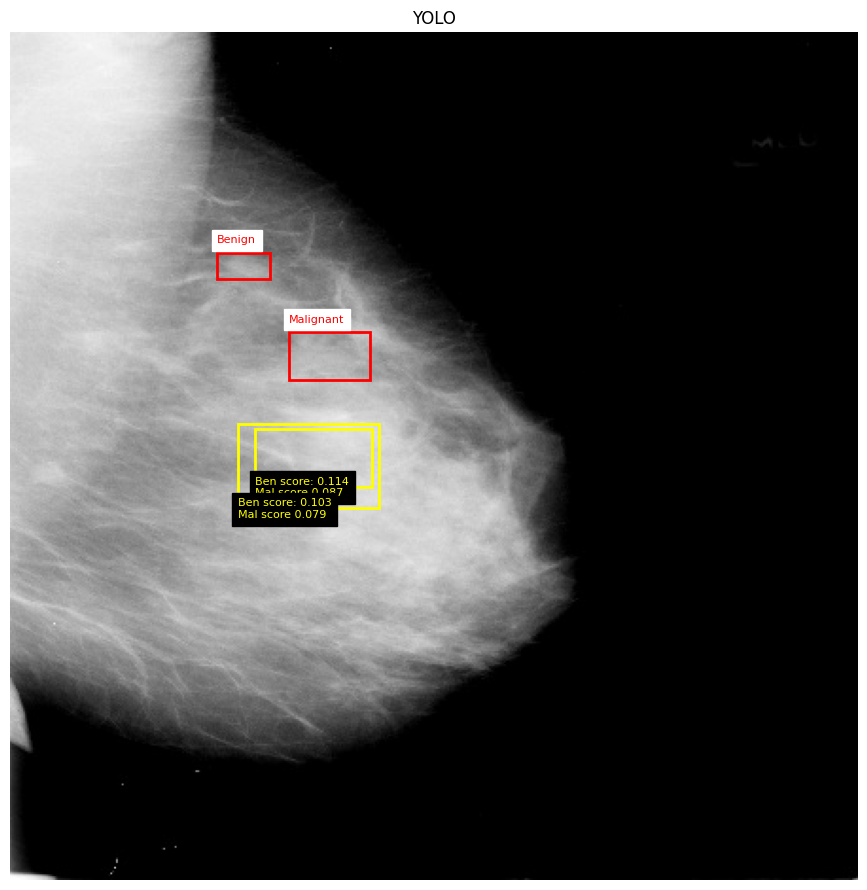

In [26]:
show_pred_example(model, "data/images/test/Mass-Test_P_00969_LEFT_MLO.jpg", "data/labels/test/Mass-Test_P_00969_LEFT_MLO.txt",
                         2, "YOLO" )

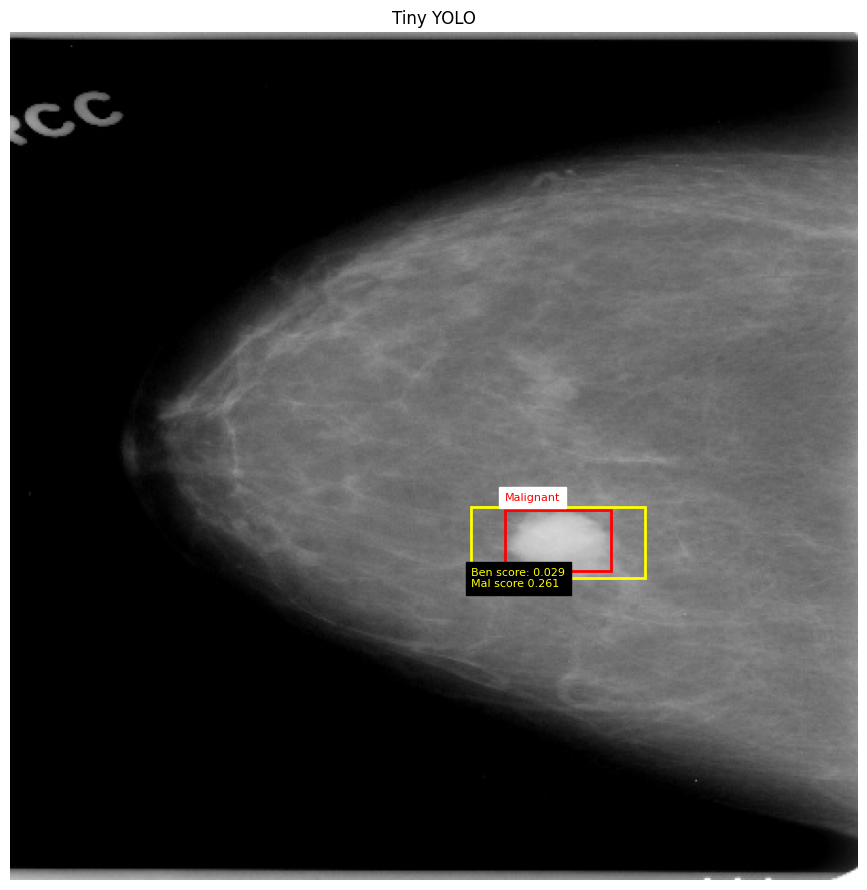

In [13]:
show_pred_example(model_tiny, "data/images/test/Mass-Test_P_00947_RIGHT_CC.jpg", "data/labels/test/Mass-Test_P_00947_RIGHT_CC.txt",
                         1, "Tiny YOLO")

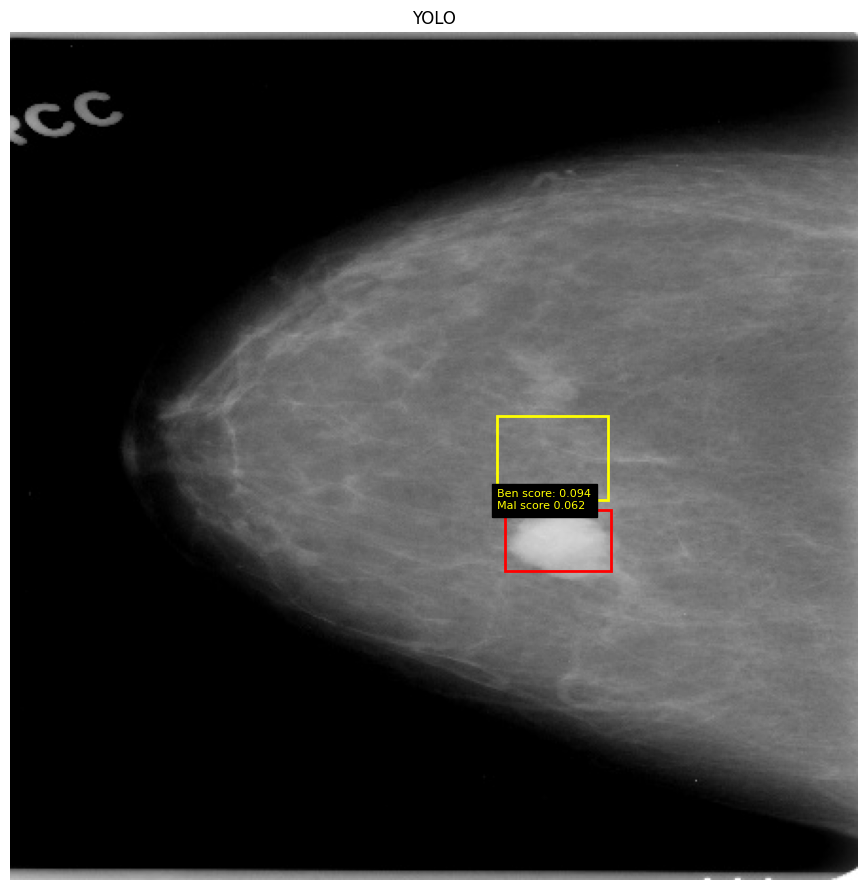

In [18]:
show_pred_example(model, "data/images/test/Mass-Test_P_00947_RIGHT_CC.jpg", "data/labels/test/Mass-Test_P_00947_RIGHT_CC.txt",
                         1, "YOLO")